In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import unconstr_solvers as solvers
import step_size as ss
import utils
import scipy.optimize as scopt

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 49.99999999999997


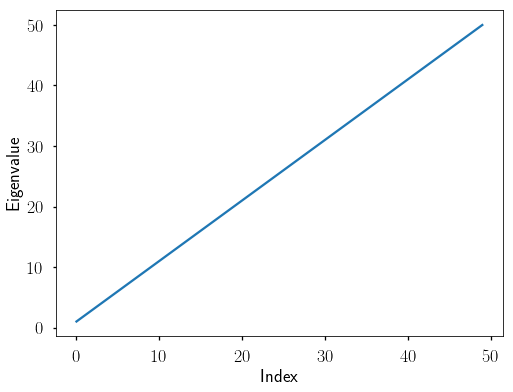

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.03186847641759608
Function value = -2.028326899083967
	 Newton
Convergence in 1 iterations
Norm of gradient = 5.279578848624909e-14
Function value = -2.0285672681144877
	 CG quad
Convergence in 36 iterations
Norm of gradient = 4.178909865165922e-07
Function value = -2.028567268114485
	 CG FR
Convergence in 73 iterations
Norm of gradient = 8.801105615725101e-07
Function value = -2.0285672681144766
	 BB 1
Convergence in 87 iterations
Norm of gradient = 9.162229953308135e-07
Function value = -2.028567268114146


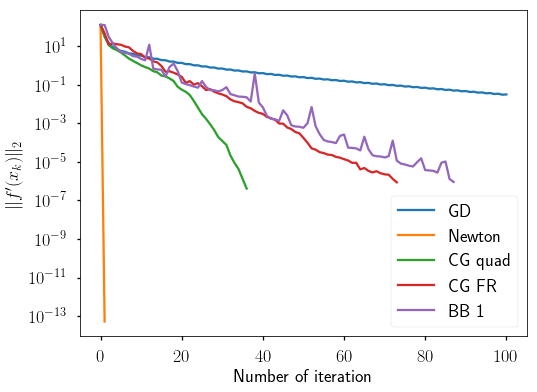

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=18)
plt.xlabel("Number of iteration", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000006486


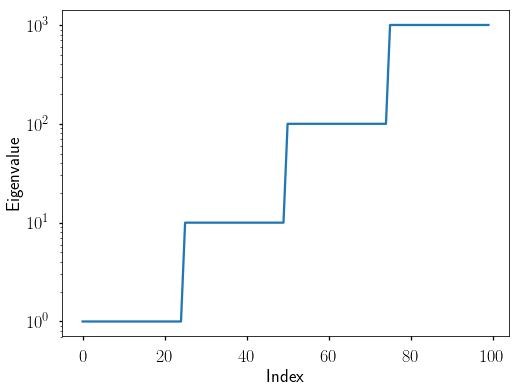

In [9]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [10]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [11]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [12]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [13]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 13.294327196595567
Function value = -1.4150271313056857
	 Newton
Convergence in 1 iterations
Norm of gradient = 1.450914314966176e-12
Function value = -11.376037273246016
	 CG quad
Convergence in 4 iterations
Norm of gradient = 5.939354417083554e-07
Function value = -11.37603727324621
	 CG FR
Convergence in 100 iterations
Norm of gradient = 2.09268588349841
Function value = -11.092279083712832
	 BB 1
Convergence in 51 iterations
Norm of gradient = 3.289681878313568e-07
Function value = -11.37603727324583


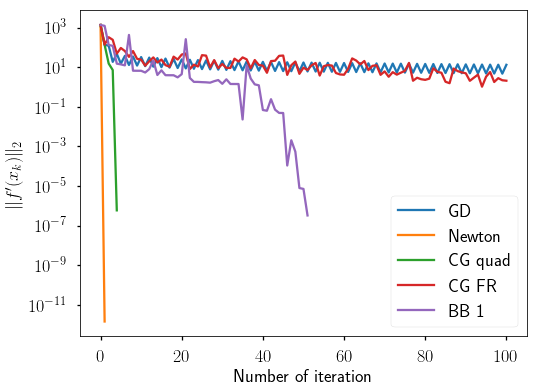

In [14]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

## Analytical center of the set of inequalities

In [15]:
n = 1000
m = 500
A = np.random.rand(n, m) * 10

In [16]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), \
                          axis=1) + 2 * x / (1 - np.power(x, 2))

hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [17]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [18]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [19]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 25 iterations
Norm of gradient = 7.352293114618139e-06
Function value = -3633.068086753965
	 Newton
Convergence in 14 iterations
Norm of gradient = 1.50889474354315e-08
Function value = -3633.06808675397
	 CG FR
Convergence in 18 iterations
Norm of gradient = 6.371082911751933e-06
Function value = -3633.068086753966
	 BB 1
Convergence in 9 iterations
Norm of gradient = 6.1703506774404384e-06
Function value = -3633.068086753966


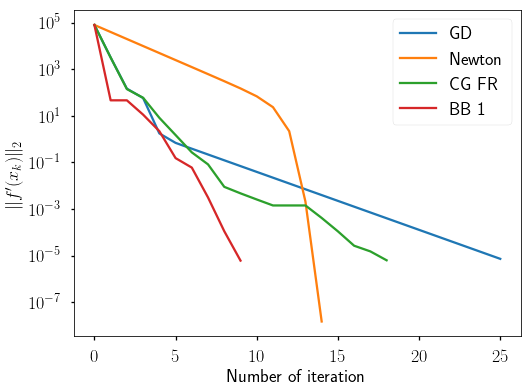

In [20]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

## Toy logistic regression with L2 regularization

In [21]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.058619717695113


In [22]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [23]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [24]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.0005601451006518247
Function value = 0.47473196423906594
	 Newton
Convergence in 29 iterations
Norm of gradient = 9.215160270869547e-06
Function value = 0.4747318832432362
	 CG FR
Convergence in 56 iterations
Norm of gradient = 8.839233684351256e-06
Function value = 0.4747318832489903
	 BB 1
Convergence in 51 iterations
Norm of gradient = 4.939795662771376e-06
Function value = 0.47473188324872234


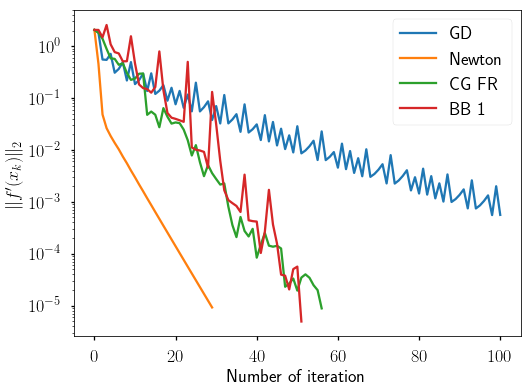

In [25]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)